<a href="https://colab.research.google.com/github/brenoslivio/MDNE_2024/blob/main/Project_2/Projeto2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SCC5920 - Mineração de Dados Não Estruturados (2024)

**Projeto 2: Mineração de Imagens - Classificação de Abelhas e Vespas**

Prof. Ricardo Marcacini

**Aluno:** Breno Livio Silva de Almeida

**NUSP:** 10276675

---

Começamos baixando o dataset que está hospedado em nosso repositório do GitHub.

In [ ]:
!git clone https://github.com/brenoslivio/MDNE_2024.git

fatal: destination path 'MDNE_2024' already exists and is not an empty directory.


Em seguida, instalamos e importamos as bibliotecas que iremos usar.

In [ ]:
!pip install mahotas
!pip install optuna
import mahotas as mt
import polars as pl
import cv2
import cv2 as cv
import numpy as np
import os
import glob
import optuna
from google.colab.patches import cv2_imshow
from skimage import io
from PIL import Image
import matplotlib.pylab as plt
import joblib
import seaborn as sns
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score, matthews_corrcoef, recall_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict

Vamos trabalhar com apenas de imagens de abelhas e vespas, considerando que usar todo o dataset seria computacionalmente custoso. Também utilizar apenas as imagens com uma qualidade boa, descrito na variável `photo_quality`. Adicionalmente, como o dataset foi previamente dividido entre treino e validação, iremos ter dois diferentes DataFrames onde o treino será usado para validação cruzada, e o validação para a validação final.

In [ ]:
dataset_path = "MDNE_2024/Project_2/dataset"

df_bees = pl.read_csv(os.path.join(dataset_path, "labels.csv")).filter((pl.col("label") == "bee") | (pl.col("label") == "wasp") & (pl.col("photo_quality") == 1) & (pl.col("path") != "wasp1\\image.png"))

df_train = df_bees.filter(pl.col("is_final_validation") == 0)
df_val = df_bees.filter((pl.col("is_validation") == 0) & (pl.col("is_final_validation") == 1))

df_val

id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
i64,str,i64,i64,i64,i64,i64,i64,i64,str
2,"""bee1\10024864894_6dc54d4b34_n.…",1,0,0,0,1,0,1,"""bee"""
4,"""bee1\1011948979_fc3637e779_w.j…",1,0,0,0,1,0,1,"""bee"""
23,"""bee1\1044467943_594f56bd36_n.j…",1,0,0,0,1,0,1,"""bee"""
37,"""bee1\1154438668_037d503906_m.j…",1,0,0,0,1,0,1,"""bee"""
40,"""bee1\11609248916_80ea630895_n.…",1,0,0,0,1,0,1,"""bee"""
…,…,…,…,…,…,…,…,…,…
5280,"""wasp1\9609935234_7bd4909970_m.…",0,1,0,0,1,0,1,"""wasp"""
5286,"""wasp1\9651510344_fe786ed064_n.…",0,1,0,0,1,0,1,"""wasp"""
5301,"""wasp1\9846164973_4245decd39_w.…",0,1,0,0,1,0,1,"""wasp"""


Verificamos a frequências das classes na porção de treino.

In [ ]:
df_train["label"].value_counts()

label,count
str,u32
"""wasp""",1798
"""bee""",2679


Em seguida, na porção de teste.

In [ ]:
df_val["label"].value_counts()

label,count
str,u32
"""wasp""",328
"""bee""",504


Podemos visualizar um exemplo aleatório do conjunto de treino.

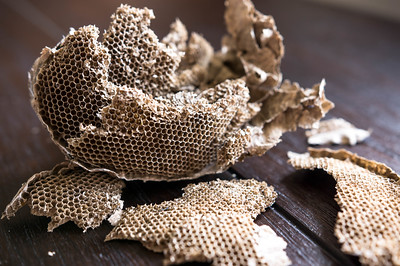

In [ ]:
image = io.imread(os.path.join(dataset_path, df_train["path"].sample(1).item().replace("\\", "/")))
cv2_imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

E visualizar um exemplo aleatório do conjunto de validação.

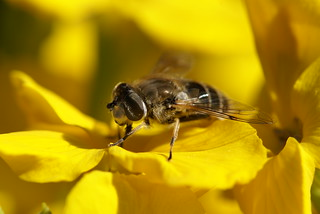

In [ ]:
image = io.imread(os.path.join(dataset_path, df_val["path"].sample(1).item().replace("\\", "/")))
cv2_imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

### Descritores de Texturas

Vamos extrair descritores de texturas propostos por (Haralick, 1973). Vamos utilizar a implementação da biblioteca Mahotas.

In [ ]:
def extract_haralick(img_path):
  image = io.imread(os.path.join(dataset_path, img_path.replace("\\", "/")))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  textures = mt.features.haralick(image)
  features = {}

  ht_mean = textures.mean(axis=0)

  for i, feature in enumerate(mt.features.texture.haralick_labels[:-1]):
    features[feature] = ht_mean[i]

  return features

df_train_haralick = df_train.with_columns(pl.col("path").map_elements(lambda x: extract_haralick(x)).alias("features")).unnest("features")
df_train_haralick

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label,Angular Second Moment,Contrast,Correlation,Sum of Squares: Variance,Inverse Difference Moment,Sum Average,Sum Variance,Sum Entropy,Entropy,Difference Variance,Difference Entropy,Information Measure of Correlation 1,Information Measure of Correlation 2
i64,str,i64,i64,i64,i64,i64,i64,i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,"""bee1\10007154554_026417cfd0_n.…",1,0,0,0,1,0,0,"""bee""",0.008061,3948.304822,0.653884,5909.264871,0.171371,208.881818,19688.754663,8.40521,13.224486,0.000146,6.025976,-0.22159,0.94823
3,"""bee1\10092043833_7306dfd1f0_n.…",1,0,0,0,1,1,0,"""bee""",0.00014,2245.1284,0.704201,3862.044483,0.111504,212.728164,13203.049532,8.767122,14.241819,0.000143,5.965364,-0.180153,0.910828
5,"""bee1\10128235063_dca17db76c_n.…",1,0,0,0,1,0,0,"""bee""",0.000122,3777.430951,0.560447,4354.136061,0.100561,246.535115,13639.113294,8.76776,14.289513,0.00014,6.085442,-0.185808,0.896628
6,"""bee1\10130729734_f68738333e_w.…",1,0,0,0,1,0,0,"""bee""",0.000803,1168.905381,0.855969,4128.8372,0.262922,292.066784,15346.443418,8.589249,12.65934,0.00032,4.922086,-0.32292,0.991448
7,"""bee1\10166485783_9cd6706c72_n.…",1,0,0,0,1,0,0,"""bee""",0.001138,910.963828,0.492477,932.590832,0.206791,248.978818,2819.399501,7.651895,11.669624,0.000458,4.760354,-0.30617,0.967111
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
5303,"""wasp1\9931084786_6c1de01c56_m.…",0,1,0,0,1,0,0,"""wasp""",0.000254,1028.118485,0.78687,2448.327669,0.11835,230.883562,8765.192192,8.379834,13.477788,0.000169,5.504822,-0.213269,0.950939
5304,"""wasp1\9974913676_226cac235d_n.…",0,1,0,0,1,0,0,"""wasp""",0.000245,3457.096761,0.475368,3350.864457,0.112277,212.752544,9946.361066,8.502058,13.880918,0.000136,6.073983,-0.194133,0.938016
5305,"""wasp1\9982829004_31a27d7db7_n.…",0,1,0,0,1,0,0,"""wasp""",0.000125,3670.520116,0.530473,3961.4218,0.088983,253.841527,12175.167083,8.635778,13.957525,0.000103,6.103158,-0.200999,0.960762


Com os descritores extraídos da parte de treino, vamos utilizar do Optuna para maximizar o F1-score médio.

In [ ]:
def objective(trial):
    C = trial.suggest_float("svm_C", 1e-6, 1e1, log=True)
    gamma = trial.suggest_categorical("svm_gamma", ["scale", "auto"])
    kernel = trial.suggest_categorical("svm_kernel", ["linear", "poly", "rbf", "sigmoid"])

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(C=C, kernel=kernel, gamma=gamma, random_state=0))
    ])

    scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring=make_scorer(f1_score, pos_label="bee"))

    return np.mean(scores)

X_train, y_train = df_train_haralick.select(pl.nth(range(10, len(df_train_haralick.columns)))).to_numpy(), df_train_haralick["label"].to_numpy()

sampler = optuna.samplers.TPESampler(seed=0)
study1 = optuna.create_study(direction="maximize", sampler=sampler)
study1.optimize(objective, n_trials=100)

print("Best hyperparameters:", study1.best_params)
print(f"Best F1-score: {study1.best_value:.4f}")

[I 2024-10-09 22:15:27,442] A new study created in memory with name: no-name-85da74da-e32b-4175-a227-2aaca27498af
[I 2024-10-09 22:15:34,795] Trial 0 finished with value: 0.7487423322651715 and parameters: {'svm_C': 0.006945356257424776, 'svm_gamma': 'scale', 'svm_kernel': 'rbf'}. Best is trial 0 with value: 0.7487423322651715.
[I 2024-10-09 22:15:41,139] Trial 1 finished with value: 0.5240138971004098 and parameters: {'svm_C': 1.7474751375465036, 'svm_gamma': 'scale', 'svm_kernel': 'sigmoid'}. Best is trial 0 with value: 0.7487423322651715.
[I 2024-10-09 22:15:50,786] Trial 2 finished with value: 0.7487423322651715 and parameters: {'svm_C': 3.1423344550041226e-06, 'svm_gamma': 'scale', 'svm_kernel': 'sigmoid'}. Best is trial 0 with value: 0.7487423322651715.
[I 2024-10-09 22:15:58,482] Trial 3 finished with value: 0.5261034094201459 and parameters: {'svm_C': 0.3927443531634939, 'svm_gamma': 'auto', 'svm_kernel': 'sigmoid'}. Best is trial 0 with value: 0.7487423322651715.
[I 2024-10-09

Best hyperparameters: {'svm_C': 1.494484265843272, 'svm_gamma': 'scale', 'svm_kernel': 'rbf'}
Best F1-score: 0.7911


Vamos extrair as características para o conjunto de validação.

In [ ]:
df_val_haralick = df_val.with_columns(pl.col("path").map_elements(lambda x: extract_haralick(x)).alias("features")).unnest("features")
df_val_haralick

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label,Angular Second Moment,Contrast,Correlation,Sum of Squares: Variance,Inverse Difference Moment,Sum Average,Sum Variance,Sum Entropy,Entropy,Difference Variance,Difference Entropy,Information Measure of Correlation 1,Information Measure of Correlation 2
i64,str,i64,i64,i64,i64,i64,i64,i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2,"""bee1\10024864894_6dc54d4b34_n.…",1,0,0,0,1,0,1,"""bee""",0.00085,5899.638137,0.479574,5939.060905,0.113345,224.754955,17856.605484,8.535219,13.433414,0.000141,6.355873,-0.217756,0.951756
4,"""bee1\1011948979_fc3637e779_w.j…",1,0,0,0,1,0,1,"""bee""",0.000256,903.109332,0.917788,5495.223697,0.147249,192.472889,21077.785456,8.597804,13.410387,0.000169,5.414926,-0.23928,0.980368
23,"""bee1\1044467943_594f56bd36_n.j…",1,0,0,0,1,0,1,"""bee""",0.00214,5288.186123,0.560274,6208.563251,0.109996,172.56559,19546.066881,8.394622,12.961501,0.00011,6.350426,-0.195994,0.939822
37,"""bee1\1154438668_037d503906_m.j…",1,0,0,0,1,0,1,"""bee""",0.000077,777.101868,0.853983,2663.23709,0.061898,249.243076,9875.846491,8.613202,14.117887,0.000083,5.739722,-0.160995,0.951708
40,"""bee1\11609248916_80ea630895_n.…",1,0,0,0,1,0,1,"""bee""",0.000191,2049.046481,0.647137,2880.766025,0.100261,229.932181,9474.017619,8.512633,13.938231,0.000143,5.90609,-0.179303,0.897315
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
5280,"""wasp1\9609935234_7bd4909970_m.…",0,1,0,0,1,0,1,"""wasp""",0.000476,870.232582,0.914593,5188.661688,0.16018,271.823308,19884.414168,8.337198,12.473341,0.000284,4.945424,-0.331919,0.992951
5286,"""wasp1\9651510344_fe786ed064_n.…",0,1,0,0,1,0,1,"""wasp""",0.000756,756.17444,0.933571,5679.594721,0.134631,254.555266,21962.204445,8.861404,13.786164,0.000131,5.453691,-0.245763,0.98736
5301,"""wasp1\9846164973_4245decd39_w.…",0,1,0,0,1,0,1,"""wasp""",0.000507,1384.240648,0.552956,1561.219168,0.156423,136.851552,4860.636026,7.93391,12.826891,0.000196,5.556098,-0.168827,0.888721


Usando os melhores hiperparâmetros encontrados com Optuna, vamos predizer as classes no conjunto de validação, obtendo as seguintes métricas de desempenho:

In [ ]:
best_params = study1.best_params

best_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(C=best_params["svm_C"], kernel=best_params["svm_kernel"], gamma=best_params["svm_gamma"]))
])

X_test, y_test = df_val_haralick.select(pl.nth(range(10, len(df_val_haralick.columns)))).to_numpy(), df_val_haralick["label"].to_numpy()

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         bee       0.76      0.86      0.81       504
        wasp       0.73      0.58      0.65       328

    accuracy                           0.75       832
   macro avg       0.74      0.72      0.73       832
weighted avg       0.75      0.75      0.74       832



Adicionalmente, temos a seguinte matriz de confusão

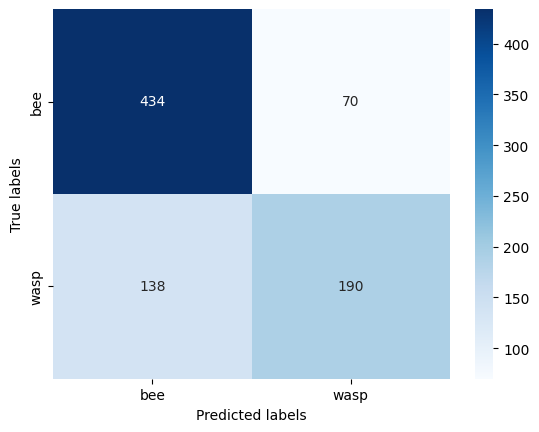

In [ ]:
cm = confusion_matrix(y_test, y_pred)

labels = np.unique(y_test)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig("cm_texture.pdf", bbox_inches='tight')
plt.show()

### Descritores de Cores

Vamos agora utilizar descritores baseados nos histogramas de cores das imagens.

In [ ]:
def extract_colors(img_path):
  color = ('b','g','r')
  dataset_hist_r = []
  dataset_hist_g = []
  dataset_hist_b = []

  image = io.imread(os.path.join(dataset_path, img_path.replace("\\", "/")))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  hists = {}

  for i, col in enumerate(color):
    histr = cv.calcHist([image],[i],None,[4],[0,256])
    if col == 'r': dataset_hist_r.append(histr)
    if col == 'g': dataset_hist_g.append(histr)
    if col == 'b': dataset_hist_b.append(histr)

  X_r = np.array(dataset_hist_r)
  X_g = np.array(dataset_hist_g)
  X_b = np.array(dataset_hist_b)

  X_colors = np.concatenate((X_r,X_g,X_b),axis=1).reshape(1, 12)

  colors_features = {}

  for i, feature in enumerate(X_colors[0]):
    colors_features[f"feature_{i}"] = feature

  return colors_features

df_train_colors = df_train.with_columns(pl.col("path").map_elements(lambda x: extract_colors(x)).alias("features")).unnest("features")
df_train_colors

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11
i64,str,i64,i64,i64,i64,i64,i64,i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,"""bee1\10007154554_026417cfd0_n.…",1,0,0,0,1,0,0,"""bee""",11066.0,7226.0,11167.0,38701.0,25249.0,22957.0,19703.0,251.0,33418.0,18236.0,16437.0,69.0
3,"""bee1\10092043833_7306dfd1f0_n.…",1,0,0,0,1,1,0,"""bee""",12590.0,28181.0,26282.0,18067.0,13483.0,31867.0,32113.0,7657.0,53969.0,23812.0,6113.0,1226.0
5,"""bee1\10128235063_dca17db76c_n.…",1,0,0,0,1,0,0,"""bee""",1662.0,4267.0,32744.0,43247.0,17347.0,31117.0,21553.0,11903.0,33180.0,43332.0,5285.0,123.0
6,"""bee1\10130729734_f68738333e_w.…",1,0,0,0,1,0,0,"""bee""",9805.0,18147.0,46777.0,30871.0,9690.0,14976.0,49500.0,31434.0,28578.0,17982.0,32554.0,26486.0
7,"""bee1\10166485783_9cd6706c72_n.…",1,0,0,0,1,0,0,"""bee""",392.0,9791.0,56478.0,1286.0,1534.0,25888.0,40207.0,318.0,4134.0,61330.0,1903.0,580.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
5303,"""wasp1\9931084786_6c1de01c56_m.…",0,1,0,0,1,0,0,"""wasp""",3862.0,31392.0,16058.0,6288.0,3509.0,34429.0,14992.0,4670.0,13672.0,28502.0,10253.0,5173.0
5304,"""wasp1\9974913676_226cac235d_n.…",0,1,0,0,1,0,0,"""wasp""",7915.0,30079.0,20230.0,9936.0,6343.0,27740.0,26763.0,7314.0,42176.0,25290.0,688.0,6.0
5305,"""wasp1\9982829004_31a27d7db7_n.…",0,1,0,0,1,0,0,"""wasp""",5174.0,21130.0,27587.0,28029.0,4898.0,21431.0,31232.0,24359.0,46848.0,34754.0,291.0,27.0


Com as características extraídas, prosseguimos para utilizar o Optuna com validação cruzada no conjunto de treino.

In [ ]:
def objective(trial):
    C = trial.suggest_float("svm_C", 1e-6, 1e1, log=True)
    gamma = trial.suggest_categorical("svm_gamma", ["scale", "auto"])
    kernel = trial.suggest_categorical("svm_kernel", ["linear", "poly", "rbf", "sigmoid"])

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(C=C, kernel=kernel, gamma=gamma, random_state=0))
    ])

    scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring=make_scorer(f1_score, pos_label="bee"))

    return np.mean(scores)

X_train, y_train = df_train_colors.select(pl.nth(range(10, len(df_train_colors.columns)))).to_numpy(), df_train_colors["label"].to_numpy()

sampler = optuna.samplers.TPESampler(seed=0)
study2 = optuna.create_study(direction="maximize", sampler=sampler)
study2.optimize(objective, n_trials=100)

print("Best hyperparameters:", study2.best_params)
print(f"Best F1-score: {study2.best_value:.4f}")

[I 2024-10-09 22:28:40,898] A new study created in memory with name: no-name-b2697a96-179f-4b98-9d72-c88ed5fa5521
[I 2024-10-09 22:28:47,711] Trial 0 finished with value: 0.7487423322651715 and parameters: {'svm_C': 0.006945356257424776, 'svm_gamma': 'scale', 'svm_kernel': 'rbf'}. Best is trial 0 with value: 0.7487423322651715.
[I 2024-10-09 22:28:53,943] Trial 1 finished with value: 0.5591428177281692 and parameters: {'svm_C': 1.7474751375465036, 'svm_gamma': 'scale', 'svm_kernel': 'sigmoid'}. Best is trial 0 with value: 0.7487423322651715.
[I 2024-10-09 22:29:02,661] Trial 2 finished with value: 0.7487423322651715 and parameters: {'svm_C': 3.1423344550041226e-06, 'svm_gamma': 'scale', 'svm_kernel': 'sigmoid'}. Best is trial 0 with value: 0.7487423322651715.
[I 2024-10-09 22:29:10,000] Trial 3 finished with value: 0.5945959408543768 and parameters: {'svm_C': 0.3927443531634939, 'svm_gamma': 'auto', 'svm_kernel': 'sigmoid'}. Best is trial 0 with value: 0.7487423322651715.
[I 2024-10-09

Best hyperparameters: {'svm_C': 6.951102804103278, 'svm_gamma': 'scale', 'svm_kernel': 'rbf'}
Best F1-score: 0.7838


Extraímos agora para o conjunto de validação.

In [ ]:
df_val_colors = df_val.with_columns(pl.col("path").map_elements(lambda x: extract_colors(x)).alias("features")).unnest("features")
df_val_colors

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11
i64,str,i64,i64,i64,i64,i64,i64,i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2,"""bee1\10024864894_6dc54d4b34_n.…",1,0,0,0,1,0,1,"""bee""",6427.0,22205.0,5874.0,33441.0,8185.0,32805.0,16503.0,10454.0,52353.0,13619.0,1861.0,114.0
4,"""bee1\1011948979_fc3637e779_w.j…",1,0,0,0,1,0,1,"""bee""",41439.0,22879.0,22545.0,19937.0,56253.0,13177.0,22140.0,15230.0,47099.0,18011.0,29521.0,12169.0
23,"""bee1\1044467943_594f56bd36_n.j…",1,0,0,0,1,0,1,"""bee""",12684.0,23242.0,18312.0,26722.0,27978.0,24880.0,24085.0,4017.0,78503.0,2047.0,343.0,67.0
37,"""bee1\1154438668_037d503906_m.j…",1,0,0,0,1,0,1,"""bee""",2862.0,18968.0,19862.0,4388.0,4924.0,19854.0,14902.0,6400.0,10282.0,16827.0,12895.0,6076.0
40,"""bee1\11609248916_80ea630895_n.…",1,0,0,0,1,0,1,"""bee""",12050.0,38937.0,23508.0,2305.0,7573.0,16367.0,44640.0,8220.0,25986.0,37594.0,11469.0,1751.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
5280,"""wasp1\9609935234_7bd4909970_m.…",0,1,0,0,1,0,1,"""wasp""",2639.0,28585.0,5195.0,21181.0,3024.0,27669.0,6083.0,20824.0,29726.0,3440.0,3307.0,21127.0
5286,"""wasp1\9651510344_fe786ed064_n.…",0,1,0,0,1,0,1,"""wasp""",15173.0,15726.0,19218.0,16763.0,17452.0,14232.0,17893.0,17303.0,18676.0,21589.0,13908.0,12707.0
5301,"""wasp1\9846164973_4245decd39_w.…",0,1,0,0,1,0,1,"""wasp""",23219.0,75593.0,5352.0,2636.0,34444.0,67583.0,4018.0,755.0,99410.0,6300.0,907.0,183.0


Em seguida, utilizando os melhores hiperparâmetros previamente encontrados, utilizamos o melhor modelo para predizer as classes no conjunto de validação.

In [ ]:
best_params = study2.best_params

best_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(C=best_params["svm_C"], kernel=best_params["svm_kernel"], gamma=best_params["svm_gamma"]))
])

X_test, y_test = df_val_colors.select(pl.nth(range(10, len(df_val_colors.columns)))).to_numpy(), df_val_colors["label"].to_numpy()

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         bee       0.80      0.81      0.81       504
        wasp       0.71      0.69      0.70       328

    accuracy                           0.76       832
   macro avg       0.75      0.75      0.75       832
weighted avg       0.76      0.76      0.76       832



Adicionalmente, temos a seguinte matriz de confusão

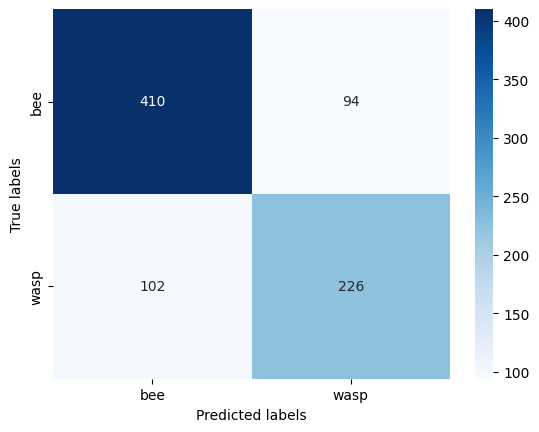

In [ ]:
cm = confusion_matrix(y_test, y_pred)

labels = np.unique(y_test)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig("cm_colors.pdf", bbox_inches='tight')
plt.show()

### Descritores de Texturas e Cores

Vamos agora utilizar ambos descritores para classificação, observando possíveis sinais de melhoria no desempenho do classificador.

In [ ]:
def objective(trial):
    C = trial.suggest_float("svm_C", 1e-6, 1e1, log=True)
    gamma = trial.suggest_categorical("svm_gamma", ["scale", "auto"])
    kernel = trial.suggest_categorical("svm_kernel", ["linear", "poly", "rbf", "sigmoid"])

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(C=C, kernel=kernel, gamma=gamma, random_state=0))
    ])

    scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring=make_scorer(f1_score, pos_label="bee"))

    return np.mean(scores)

df_concat = pl.concat([df_train_colors.select(pl.nth(range(10, len(df_train_colors.columns)))), df_train_haralick.select(pl.nth(range(10, len(df_train_haralick.columns))))], how="horizontal")

X_train, y_train = df_concat.to_numpy(), df_train_colors["label"].to_numpy()

sampler = optuna.samplers.TPESampler(seed=0)
study3 = optuna.create_study(direction="maximize", sampler=sampler)
study3.optimize(objective, n_trials=100)

print("Best hyperparameters:", study3.best_params)
print(f"Best F1-score: {study3.best_value:.4f}")

[I 2024-10-09 22:39:32,491] A new study created in memory with name: no-name-7e65bec6-ac93-4fd3-9787-63776aa27c9c
[I 2024-10-09 22:39:39,562] Trial 0 finished with value: 0.7487423322651715 and parameters: {'svm_C': 0.006945356257424776, 'svm_gamma': 'scale', 'svm_kernel': 'rbf'}. Best is trial 0 with value: 0.7487423322651715.
[I 2024-10-09 22:39:46,723] Trial 1 finished with value: 0.5491739919954272 and parameters: {'svm_C': 1.7474751375465036, 'svm_gamma': 'scale', 'svm_kernel': 'sigmoid'}. Best is trial 0 with value: 0.7487423322651715.
[I 2024-10-09 22:39:56,964] Trial 2 finished with value: 0.7487423322651715 and parameters: {'svm_C': 3.1423344550041226e-06, 'svm_gamma': 'scale', 'svm_kernel': 'sigmoid'}. Best is trial 0 with value: 0.7487423322651715.
[I 2024-10-09 22:40:03,681] Trial 3 finished with value: 0.5497132700390855 and parameters: {'svm_C': 0.3927443531634939, 'svm_gamma': 'auto', 'svm_kernel': 'sigmoid'}. Best is trial 0 with value: 0.7487423322651715.
[I 2024-10-09

Best hyperparameters: {'svm_C': 4.677950525296623, 'svm_gamma': 'scale', 'svm_kernel': 'rbf'}
Best F1-score: 0.8209


Com os melhores hiperparâmetros encontrados com Optuna, predizendo as classes no conjunto de validação, temos os seguintes resultados

In [ ]:
best_params = study3.best_params

best_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(C=best_params["svm_C"], kernel=best_params["svm_kernel"], gamma=best_params["svm_gamma"]))
])

df_concat_test = pl.concat([df_val_colors.select(pl.nth(range(10, len(df_val_colors.columns)))), df_val_haralick.select(pl.nth(range(10, len(df_val_haralick.columns))))], how="horizontal")

X_test, y_test = df_concat_test.to_numpy(), df_val_colors["label"].to_numpy()

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         bee       0.84      0.83      0.83       504
        wasp       0.74      0.75      0.75       328

    accuracy                           0.80       832
   macro avg       0.79      0.79      0.79       832
weighted avg       0.80      0.80      0.80       832



Adicionalmente, temos a seguinte matriz de confusão

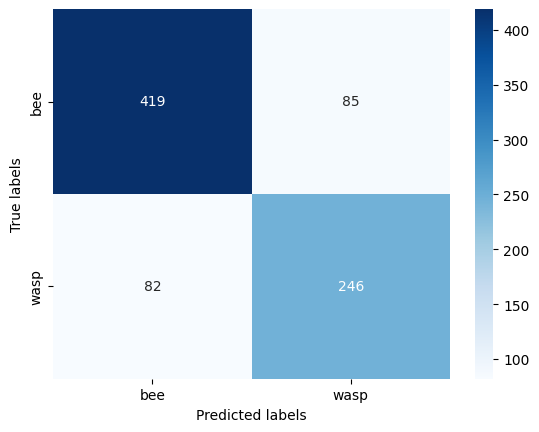

In [ ]:
cm = confusion_matrix(y_test, y_pred)

labels = np.unique(y_test)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig("cm_texture_colors.pdf", bbox_inches='tight')
plt.show()

### Embeddings

De forma alternativa aos descritores artesanais, vamos também extrair representações numéricas utilizando o modelo de aprendizado profundo ResNet18.

In [ ]:
model = models.resnet18(pretrained=True)

layer = model._modules.get('avgpool')
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 186MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Vamos extrair os embeddings para o conjunto de treino.

In [ ]:
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def extract_embeddings(img_path):
    img = Image.open(os.path.join(dataset_path, img_path.replace("\\", "/")))
    img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))

    embedding = torch.zeros(512)

    def capture_embedding(m, i, o):
        embedding.copy_(o.data.reshape(o.data.size(1)))

    h = layer.register_forward_hook(capture_embedding)
    model(img)

    h.remove()

    embeddings_feat = {}

    for i, feature in enumerate(np.array(embedding)):
      embeddings_feat[f"embedding_{i}"] = feature

    return embeddings_feat

df_train_embed = df_train.with_columns(pl.col("path").map_elements(lambda x: extract_embeddings(x)).alias("features")).unnest("features").drop_nulls()
df_train_embed

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,embedding_10,embedding_11,embedding_12,embedding_13,embedding_14,embedding_15,embedding_16,embedding_17,embedding_18,embedding_19,embedding_20,embedding_21,embedding_22,embedding_23,embedding_24,embedding_25,embedding_26,…,embedding_475,embedding_476,embedding_477,embedding_478,embedding_479,embedding_480,embedding_481,embedding_482,embedding_483,embedding_484,embedding_485,embedding_486,embedding_487,embedding_488,embedding_489,embedding_490,embedding_491,embedding_492,embedding_493,embedding_494,embedding_495,embedding_496,embedding_497,embedding_498,embedding_499,embedding_500,embedding_501,embedding_502,embedding_503,embedding_504,embedding_505,embedding_506,embedding_507,embedding_508,embedding_509,embedding_510,embedding_511
i64,str,i64,i64,i64,i64,i64,i64,i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,"""bee1\10007154554_026417cfd0_n.…",1,0,0,0,1,0,0,"""bee""",1.656034,1.150079,1.59277,4.585748,1.32508,0.399209,0.691994,1.74444,0.413434,0.710962,0.390651,1.740524,0.557355,1.355927,0.26711,1.591231,0.142127,2.499353,1.769034,1.913502,1.046385,2.219399,1.055526,1.724429,2.764673,0.064915,1.480036,…,1.244615,0.952297,0.826904,0.393932,0.091564,0.136522,0.520662,1.077451,1.039944,0.07175,1.891609,0.513736,0.134144,3.23661,0.138047,0.880893,0.004248,0.085919,4.57311,2.224537,0.900525,1.404641,0.178079,2.731996,0.587629,0.590353,0.533015,1.011146,0.221801,1.837299,0.882562,2.123458,2.080996,1.106529,0.946238,1.329882,0.052026
3,"""bee1\10092043833_7306dfd1f0_n.…",1,0,0,0,1,1,0,"""bee""",0.163239,0.3565,1.220858,1.958049,1.139265,0.584579,2.109976,1.310278,0.612006,0.877367,0.485608,0.101202,1.527157,0.613879,0.913922,0.54313,2.240493,5.73844,2.707292,1.910687,1.901318,1.169021,0.089217,1.253332,1.008647,1.516607,1.855472,…,1.149608,0.622582,0.661147,0.227419,0.288196,0.146031,1.689142,0.093026,1.382779,0.356375,0.745604,1.871413,0.265956,3.062068,0.787671,5.807712,1.029242,0.086466,1.222842,0.916699,0.908044,1.467534,0.811367,0.413152,0.185794,0.977813,0.02374,0.87409,0.738553,0.093949,0.156035,4.045156,0.531816,0.594989,0.312187,0.277257,0.060972
5,"""bee1\10128235063_dca17db76c_n.…",1,0,0,0,1,0,0,"""bee""",0.640751,0.549573,0.305969,1.966503,2.055373,2.870137,2.589531,0.558019,0.49601,0.246089,0.653363,0.378269,1.026979,0.712123,0.019544,0.33051,0.339665,4.905179,1.385486,1.65102,1.278139,1.566634,0.833995,0.218337,1.205728,1.020643,0.310432,…,1.129666,0.707398,1.554405,1.404819,0.368668,0.276122,1.507757,0.0,1.129876,0.256574,2.076206,0.699231,0.598575,3.088331,0.141056,2.830254,0.037044,0.307626,0.006048,0.246722,0.013588,1.386742,0.55019,0.005462,1.201962,1.991938,0.038812,0.473947,0.854096,0.057953,0.341086,5.026528,0.369429,0.0,1.005453,0.173616,0.756549
6,"""bee1\10130729734_f68738333e_w.…",1,0,0,0,1,0,0,"""bee""",0.572083,1.532626,1.259644,1.567945,1.220702,1.175466,0.666279,0.699707,0.129576,0.291338,0.408902,0.077068,1.129686,0.438807,0.371769,1.103351,0.362818,4.832753,1.340512,1.067491,2.347697,2.236967,0.579783,0.930365,1.607205,0.987766,2.063769,…,0.868638,0.094648,0.747457,0.166156,0.340136,0.081913,1.298885,0.285489,1.128373,1.106088,3.08335,1.290821,0.114953,3.165866,1.450479,2.635821,0.253944,0.03424,0.841055,0.861179,0.82381,0.570422,0.279802,0.767839,0.436698,0.410146,0.288589,1.432087,0.414766,0.326829,0.181818,2.289161,1.734332,0.122868,0.719731,0.193919,0.350997
7,"""bee1\10166485783_9cd6706c72_n.…",1,0,0,0,1,0,0,"""bee""",0.148513,0.065854,0.274415,2.156327,0.559714,0.526637,2.241199,2.332425,0.174586,0.768668,0.489905,0.509618,0.03389,0.341512,0.772464,1.167563,0.241

Após a extração dos embeddings, utilizamos do Optuna para achar os melhores hiperparâmetros para SVMs

In [ ]:
def objective(trial):
    C = trial.suggest_float("svm_C", 1e-6, 1e1, log=True)
    gamma = trial.suggest_categorical("svm_gamma", ["scale", "auto"])
    kernel = trial.suggest_categorical("svm_kernel", ["linear", "poly", "rbf", "sigmoid"])

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(C=C, kernel=kernel, gamma=gamma, random_state=0))
    ])

    scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring=make_scorer(f1_score, pos_label="bee"))

    return np.mean(scores)

X_train, y_train = df_train_embed.select(pl.nth(range(10, len(df_train_embed.columns)))).to_numpy(), df_train_embed["label"].to_numpy()

sampler = optuna.samplers.TPESampler(seed=0)
study4 = optuna.create_study(direction="maximize", sampler=sampler)
study4.optimize(objective, n_trials=100)

print("Best hyperparameters:", study4.best_params)
print(f"Best F1-score: {study4.best_value:.4f}")

[I 2024-10-09 22:57:16,021] A new study created in memory with name: no-name-06ed5f2e-7509-45d6-83cf-6d19299cf8c9
[I 2024-10-09 22:57:48,968] Trial 0 finished with value: 0.7486719130360273 and parameters: {'svm_C': 0.006945356257424776, 'svm_gamma': 'scale', 'svm_kernel': 'rbf'}. Best is trial 0 with value: 0.7486719130360273.
[I 2024-10-09 22:57:56,886] Trial 1 finished with value: 0.9344093207256476 and parameters: {'svm_C': 1.7474751375465036, 'svm_gamma': 'scale', 'svm_kernel': 'sigmoid'}. Best is trial 1 with value: 0.9344093207256476.
[I 2024-10-09 22:58:30,496] Trial 2 finished with value: 0.7486719130360273 and parameters: {'svm_C': 3.1423344550041226e-06, 'svm_gamma': 'scale', 'svm_kernel': 'sigmoid'}. Best is trial 1 with value: 0.9344093207256476.
[I 2024-10-09 22:58:40,410] Trial 3 finished with value: 0.9489044594049378 and parameters: {'svm_C': 0.3927443531634939, 'svm_gamma': 'auto', 'svm_kernel': 'sigmoid'}. Best is trial 3 with value: 0.9489044594049378.
[I 2024-10-09

Best hyperparameters: {'svm_C': 0.0033979551869755616, 'svm_gamma': 'scale', 'svm_kernel': 'linear'}
Best F1-score: 0.9533


Em seguida, extraímos embeddings do conjunto de validação

In [ ]:
df_val_embed = df_val.with_columns(pl.col("path").map_elements(lambda x: extract_embeddings(x)).alias("features")).unnest("features").drop_nulls()
df_val_embed

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,embedding_10,embedding_11,embedding_12,embedding_13,embedding_14,embedding_15,embedding_16,embedding_17,embedding_18,embedding_19,embedding_20,embedding_21,embedding_22,embedding_23,embedding_24,embedding_25,embedding_26,…,embedding_475,embedding_476,embedding_477,embedding_478,embedding_479,embedding_480,embedding_481,embedding_482,embedding_483,embedding_484,embedding_485,embedding_486,embedding_487,embedding_488,embedding_489,embedding_490,embedding_491,embedding_492,embedding_493,embedding_494,embedding_495,embedding_496,embedding_497,embedding_498,embedding_499,embedding_500,embedding_501,embedding_502,embedding_503,embedding_504,embedding_505,embedding_506,embedding_507,embedding_508,embedding_509,embedding_510,embedding_511
i64,str,i64,i64,i64,i64,i64,i64,i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2,"""bee1\10024864894_6dc54d4b34_n.…",1,0,0,0,1,0,1,"""bee""",0.073299,0.694999,1.460509,2.136836,3.199918,0.057925,1.363663,1.177954,0.681427,0.151512,0.369275,0.151505,1.034565,1.95362,0.127674,0.53738,0.527235,5.859969,2.045899,3.227757,1.041126,1.313828,0.694115,1.402866,0.226312,0.776975,0.745277,…,1.400438,0.135059,1.991893,0.387704,0.526591,0.694013,2.515328,0.305568,0.438602,0.078973,3.023655,0.399505,0.169691,2.591745,0.546189,3.107877,1.1323,0.190776,0.043817,1.375714,0.036293,0.630287,0.267295,0.053811,0.969556,0.414061,0.097452,0.419993,0.242121,0.344299,0.08222,3.898879,0.674655,0.967264,0.833653,1.297752,0.087224
4,"""bee1\1011948979_fc3637e779_w.j…",1,0,0,0,1,0,1,"""bee""",0.725574,0.853309,0.63183,1.766578,1.526711,0.732414,2.464983,2.474765,0.556929,0.062938,0.84098,0.003904,2.409343,0.47961,0.79976,0.910708,0.353284,4.353446,1.886816,4.009683,0.004247,2.75814,0.550528,2.026057,0.453514,0.117841,1.523252,…,1.286835,1.120632,0.152444,0.265957,1.312674,0.51662,0.232285,0.868083,0.94982,0.436767,1.988773,1.38637,0.353476,1.537,2.308066,3.926969,0.591004,1.016996,0.62328,0.485195,0.444878,0.214869,2.180505,0.57119,0.120091,1.217872,0.034115,2.444765,0.283631,2.209306,0.230958,3.449002,2.016582,0.463996,0.819731,0.975367,0.845313
23,"""bee1\1044467943_594f56bd36_n.j…",1,0,0,0,1,0,1,"""bee""",0.285263,0.036534,0.023556,1.489104,1.866251,0.661312,3.261603,2.288575,2.436882,0.862776,0.997903,0.549283,2.165411,1.718975,0.456047,0.796439,0.937491,4.037841,2.7724,2.263875,2.147044,4.031962,0.0,0.020196,1.829499,1.298991,3.019602,…,3.095832,0.621604,0.759573,0.133184,0.502464,0.851069,0.708019,0.069958,0.247486,1.164783,1.020229,0.659806,0.455679,2.204592,0.012328,1.910062,1.12788,1.453174,0.303196,0.828524,0.051871,1.25926,0.610319,0.07304,1.66118,0.423488,0.372973,0.902864,0.531825,0.123979,0.424018,4.973538,0.099765,0.073581,1.368384,0.142858,0.786007
37,"""bee1\1154438668_037d503906_m.j…",1,0,0,0,1,0,1,"""bee""",0.036162,0.0,3.737942,0.183235,2.857392,0.203159,0.560728,1.16503,3.855284,3.536415,0.512797,1.2444,1.607293,2.651334,2.173604,1.858334,1.235375,1.554774,1.636014,1.925512,1.527329,3.114194,0.0,0.00749,2.216068,1.117527,8.370857,…,0.326116,0.869721,0.63198,0.0,0.344904,0.520364,1.2971,0.0,2.784094,0.143423,0.48033,1.602568,2.450047,0.0,0.004895,0.970848,0.733353,2.714703,1.174632,0.98471,1.735052,0.332415,0.011949,1.010421,0.451807,0.520488,0.148176,0.052338,0.972354,2.369049,1.07717,0.102633,0.804732,0.748775,0.609048,1.559366,1.745638
40,"""bee1\11609248916_80ea630895_n.…",1,0,0,0,1,0,1,"""bee""",0.0,0.762041,1.952315,1.345335,0.240004,0.464166,1.568747,0.080576,0.217681,0.550321,1.757518,0.307953,1.280411,1.235334,0.250247,1.784106,1.688963,6.810296,2.294722,1.098842,1.23

Com os melhores hiperparâmetros encontrados, temos os seguintes resultados da predição das classes no conjunto de validação

In [ ]:
best_params = study4.best_params

best_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(C=best_params["svm_C"], kernel=best_params["svm_kernel"], gamma=best_params["svm_gamma"]))
])

X_test, y_test = df_val_embed.select(pl.nth(range(10, len(df_val_embed.columns)))).to_numpy(), df_val_embed["label"].to_numpy()

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         bee       0.94      0.95      0.95       504
        wasp       0.93      0.91      0.92       327

    accuracy                           0.94       831
   macro avg       0.94      0.93      0.93       831
weighted avg       0.94      0.94      0.94       831



Adicionalmente, temos a seguinte matriz de confusão

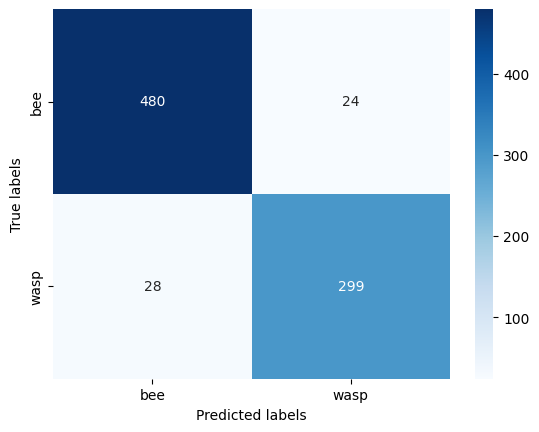

In [ ]:
cm = confusion_matrix(y_test, y_pred)

labels = np.unique(y_test)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig("cm_embed.pdf", bbox_inches='tight')
plt.show()

### Uso do conhecimento

Podemos fazer o deploy do nosso modelo mais robusto como uma aplicação em Streamlit. Vamos utilizar do modelo usando embeddings, sendo computacionalmente factível de usar no Streamlit.

In [ ]:
X, y = df_train_embed.select(pl.nth(range(10, len(df_train_embed.columns)))).to_numpy(), df_train_embed["label"].to_numpy()

best_params = study4.best_params

best_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(C=best_params["svm_C"], kernel=best_params["svm_kernel"], gamma=best_params["svm_gamma"]))
])

model = best_model.fit(X, y)

joblib.dump(model, "best_model_embed.pkl")

['best_model_embed.pkl']